# Deteccion de fraude en transacciones
## analisis de transacciones

**- Fuente: Credit Fraud || Dealing with Imbalanced Datasets (Kaggle)**  

**- Usuario: Janio Martinez Bachman**

*Aclaracion importante, el paso a paso es lo mismo que publico el autor, lo unico que estoy haciendo yo en este caso es seguir el mismo procedimiento explicando con mis propias palabras cada paso, para poder comprender como se realiza un analisis de datos y su posterior procesamiento, obviamente modifique algunos nombres de variables para poder entender que era cada una y tuve que usar otras funciones de las librerias ya que algunas quedaron obsoletas*

In [66]:
!pip install pandas matplotlib seaborn scikit-learn tensorflow imblearn

In [67]:
import numpy as np # para las operaciones de algebra lineal
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE # reduccion de caracteristicas/dimensionalidad *1
from sklearn.decomposition import PCA, TruncatedSVD # reduccion de caracteristicas/dimensionalidad *2
import matplotlib.patches as mpatches
import time

# librerias de clasificacion
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


Doy un vistazo rapido a la forma del dataset, cuantas columnas y ejemplos tenemos en el dataframe cargado 

In [68]:
fraude = pd.read_csv("data/creditcard.csv")
fraude.shape

(284807, 31)

Y los primeros 5 datos son:

In [69]:
fraude.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [70]:
fraude.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


En las columnas identificadas con V, podemos notar un rango, este rango es una posible normalizacion de los valores originales  

que significa cada V?  
- No esta del todo claro, sin embargo, en la fuente dice que puede ser un producto de la reduccion de caracteristicas mediante la tecnica PCA, con el fin no solo de reducir la dimensionalidad si no tambien de resguardar la privacidad de los usuarios

Por otra parte la caracteristica Class, tiene dos variables:  
- 1 si la operacion/transaccion fue un fraude 
- 0 si no lo fue

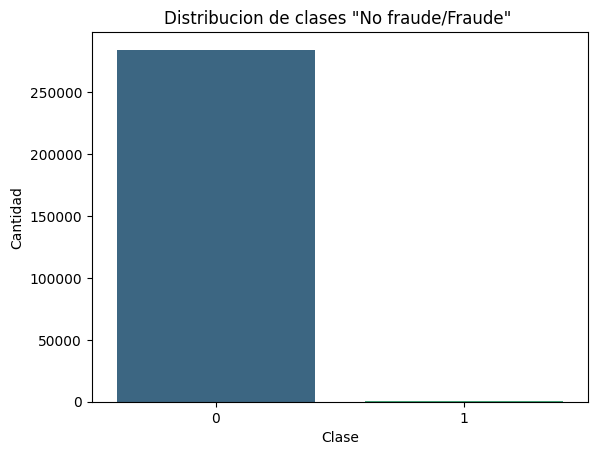

In [71]:
sns.countplot(x='Class', data=fraude, palette='viridis')
plt.title('Distribucion de clases "No fraude/Fraude" ')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.show()

In [72]:
porcentaje_fraude = fraude.Class.value_counts(normalize=True) * 100
print(porcentaje_fraude)

Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


- Teniendo en cuenta este conjunto, el porcentaje de fraudes por transacciones es de ~ 0.173%
para poder crear un algoritmo que evalue correctamente necesitamos sobremuestrear la clase 1(transaccion marcada como fraude) para poder balancear con la clase 0(no fraude)

**Antes de realizar el resampleo me quiero asegurar de que que no hayan datos nulos**

In [73]:
fraude.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [74]:
fraude.isnull().sum().max()

np.int64(0)

In [75]:
fraude.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

(0.0, 172792.0)

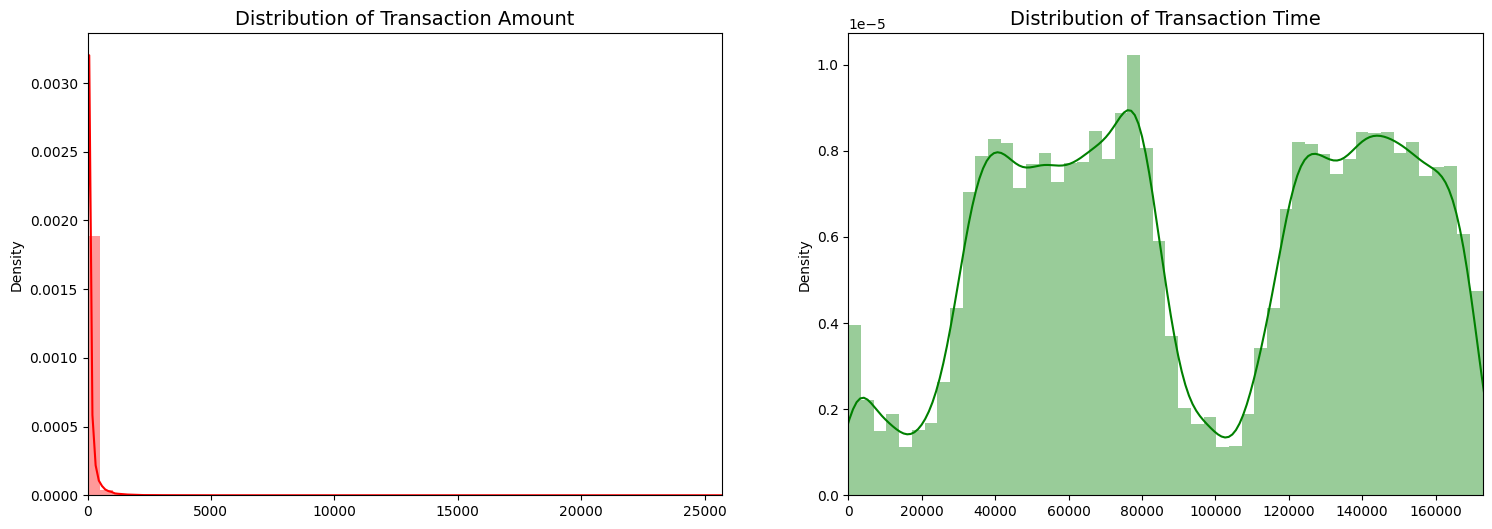

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

amount_val = fraude['Amount'].values
time_val = fraude['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='g')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

- Teniendo en cuenta lo fuertemente sesgada que se encuentra la distribucion Amount, usaremos RobustScaler para escalar las caracteristicas ya que es menos sensilbe para cuando hay posibles outliers


In [77]:
from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()

fraude['Scaled_amount'] = rob_scaler.fit_transform(fraude.Amount.values.reshape(-1,1))
fraude['Scaled_time'] = rob_scaler.fit_transform(fraude.Time.values.reshape(-1,1))

In [78]:
fraude.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Scaled_amount,Scaled_time
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1.783274,-0.994983
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.269825,-0.994983
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,4.983721,-0.994972
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1.418291,-0.994972
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.670579,-0.994960


Ya teniendo las dos caracteristicas escaladas procedo a eliminar las caracteristicas origen y ubicar las dos caracteristicas entre las 2 primeras caracteristicas visibles

In [79]:
fraude.drop(['Amount','Time'], axis=1, inplace=True)

scaled_amount = fraude['Scaled_amount']
scaled_time = fraude['Scaled_time']

fraude.drop(['Scaled_amount','Scaled_time'], axis=1, inplace=True)
fraude.insert(0, 'Scaled_amount', scaled_amount)
fraude.insert(1,'Scaled_time', scaled_time)

fraude.head()

,Scaled_amount,Scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


ahora antes de modificar el muestreo de los datos, voy a seleccionar del dataset original los valores para poder dividirlos en conjuntos de entrenamiento y evaluacion


In [80]:
from sklearn.model_selection import StratifiedKFold

X = fraude.drop('Class', axis=1)
y = fraude['Class']

#al ser de 5 folds obtendremos 5 variacions de conjuntos de prueba y entrenamiento
stratified = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
#en cada bucle eliminara una quinta parte del conjunto test/train para ir variando en cada conjunto
for train_index, test_index in stratified.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
    print("Train:", train_index, " Test:",test_index)

Train: [ 30473  30496  31002 ... 284804 284805 284806]  Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806]  Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806]  Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806]  Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868]  Test: [212516 212644 213092 ... 284804 284805 284806]


Lo siguiente es solo para asegurarse que las etiquetas hayan quedado distribuidas igual que en el original

In [81]:
#chequeo de la distribucion de train/test
#convertimos los datos en arrays
original_ytrain_numpy = original_ytrain.values
original_ytest_numpy = original_ytest.values

#chequeamos que el porcentaje de distribucion sea el mismo tanto en train como en test
#unique nos devolvera tanto las etiquetas unicas como la cantidad de veces que aparece cada una en el array
#unique_label almacenara las etiquetas unicas y counts_label la cantidad de veces que aparece cada una de ellas
ytrain_unique_label, ytrain_counts_label = np.unique(original_ytrain_numpy, return_counts=True)
ytest_unique_label, ytest_counts_label = np.unique(original_ytest_numpy, return_counts=True)

In [82]:
print("Distribucion de original_ytrain")
print(f'La etiqueta 0 aparece: {ytrain_counts_label[0]/len(original_ytrain)*100:.2f}%      y la etiqueta 1 aparece: {ytrain_counts_label[1]/len(original_ytrain)*100:.2f}%\n')
print("Distribucion de original_ytest")
print(f'La etiqueta 0 aparece: {ytest_counts_label[0]/len(original_ytest)*100:.2f}%      y la etiqueta 1 aparece: {ytest_counts_label[1]/len(original_ytest)*100:.2f}%\n')

Distribucion de original_ytrain
La etiqueta 0 aparece: 99.83%      y la etiqueta 1 aparece: 0.17%

Distribucion de original_ytest
La etiqueta 0 aparece: 99.83%      y la etiqueta 1 aparece: 0.17%



**Ahora queda balancear el dataframe entre los labels 0 y 1**  
procedo a:
1. Mezclar aleatoriamente los valores del dataset original
2. Disminuir la cantidad de filas con labels=0, ya que es mas factible que crear unos valores "sinteticos" de labels=1, debido a que estos representan menos del 1%
3. Combinar los valores en un nuevo DF
4. Tras la union de ambos valores con etiquetas 1 y 0, vuelvo a mezclarlos aleatoriamente


In [83]:
#1
fraude = fraude.sample(frac=1)
#para que me devuelva la cantidad de valores que tienen las etiquetas Class=1
cantidad_fraudes = len(fraude[fraude['Class']==1])

fraude_df = fraude.loc[fraude['Class']==1]
#2
no_fraude_df = fraude.loc[fraude['Class']==0][:cantidad_fraudes]

#3
distribucion_balanceada = pd.concat([fraude_df,no_fraude_df])

#4
distribucion_balanceada = distribucion_balanceada.sample(frac=1, random_state=42)

distribucion_balanceada.head()


,Scaled_amount,Scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
54,-0.293579,-0.994549,1.295668,0.341483,0.081505,0.566746,-0.110459,-0.766325,0.073155,-0.168304,...,-0.065983,-0.323607,-0.929781,0.063809,-0.193565,0.287574,0.127881,-0.023731,0.025200,0
212644,9.863900,0.637343,-2.356348,1.746360,-6.374624,1.772205,-3.439294,1.457811,-0.362577,1.443791,...,0.194810,0.857942,0.621203,0.964817,-0.619437,-1.732613,0.108361,1.130828,0.415703,1
94201,-0.227486,-0.233955,1.415459,-0.566274,0.461507,-0.652083,-1.271287,-1.141814,-0.649364,-0.077476,...,-0.092263,-0.167548,-0.721416,0.183589,0.295117,0.144377,-0.508389,-0.008746,0.016239,0
151103,0.164326,0.116695,1.707857,0.024881,-0.488140,3.787548,1.139451,2.914673,-0.743358,0.699136,...,-0.368014,0.010865,0.548258,0.091218,-1.007959,-0.082183,0.179709,0.007738,-0.068841,1
68633,-0.290924,-0.371433,1.296231,0.417447,0.193963,0.901644,0.130531,-0.371634,0.158126,-0.202669,...,-0.029559,-0.112114,-0.220002,-0.121022,-0.440454,0.671540,-0.413518,0.032838,0.020600,1


graficamos para corroborar que el balance haya sido correctamente realizado

Text(0.5, 1.0, 'Distribucion de etiquetas')

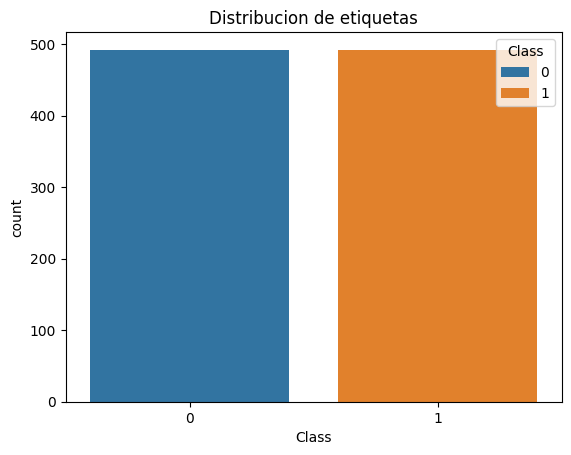

In [84]:
colors=["#128f2d", "#ee2f2f"]
sns.countplot(data=distribucion_balanceada, x='Class', hue='Class')
plt.title("Distribucion de etiquetas")

Siguiente paso, revisar las correlaciones entre las caracteristicas nombradas con 'Vxx', cuales pueden ser influyentes y cuales no con respecto a las etiquetas de 'Class'  
para esto voy a centrarme unicamente en ver las relaciones con 'Class' respecto a estas

<Axes: >

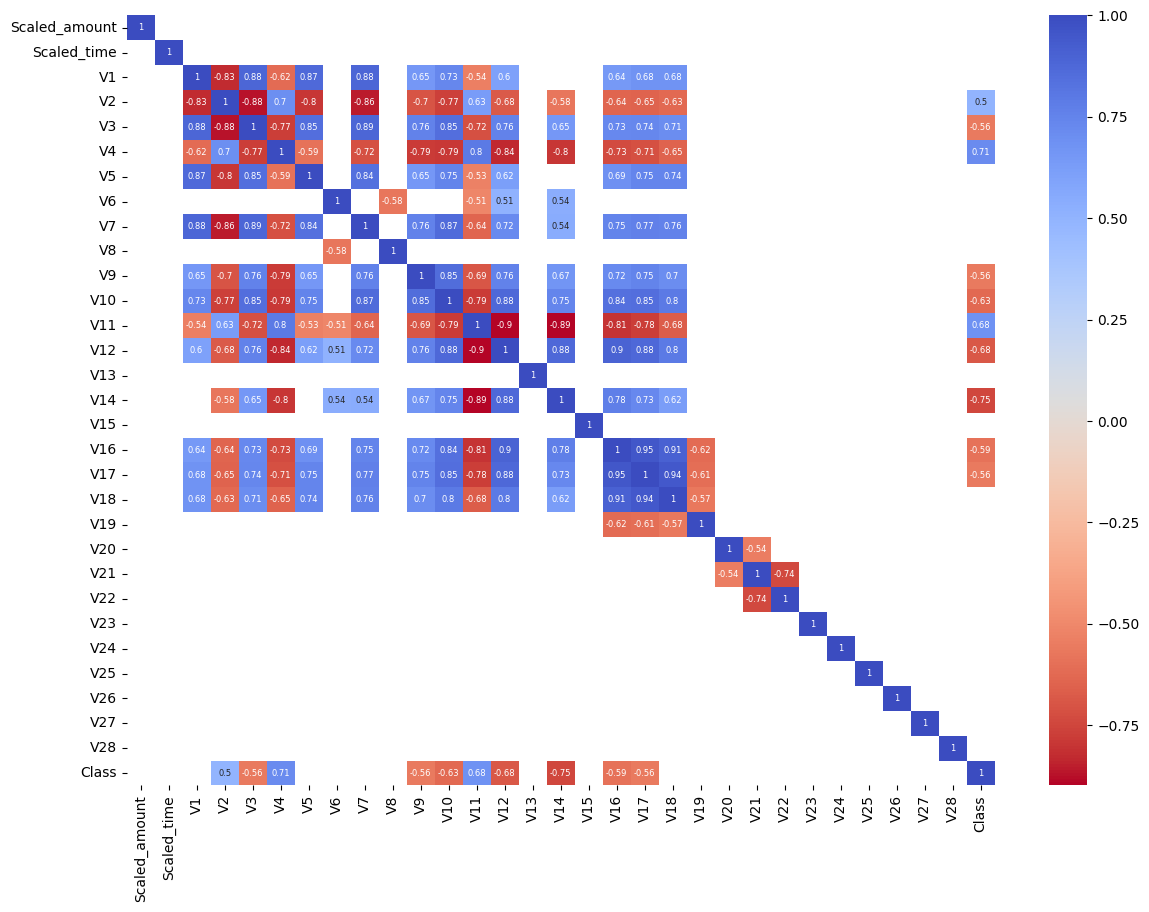

In [85]:
fig, ax = plt.subplots(figsize=(14,10))
corr_dist_balanceada = distribucion_balanceada.corr()

##voy a definir colores y limites personalizados para notar con mayor claridad los saltos entre valores
#colores = ["#5f0000","#ff0505","#cc521a","#ffecca", "#D0DFDC", "#d2fff2", "#02ffb3", "#0099ff", "#0044ff"]
#mi_paleta = mcolors.ListedColormap(colores)
#limites_colores = [-1, -.75, -.5, -.25, 0, .25, .5, .75, 1]
#sns.heatmap(corr_dist_balanceada, cmap=mi_paleta, vmin=-1, vmax=1,annot=True,fmt=".2f",annot_kws={'size': 6},linewidths=.5,ax=ax[1], cbar_kws={'ticks':limites_colores})

#esta mascara la voy a usar para que aparezcan valores en el grafico que superen .45 o -.45(el rango los elegi al realizar varios chequeos de la correlacion)
mask_filtro = (corr_dist_balanceada<.47) & (corr_dist_balanceada>-.5)
sns.heatmap(corr_dist_balanceada, cmap='coolwarm_r', annot_kws={'size':6}, ax=ax, annot=True, mask=mask_filtro)





de esas 10 features Voy a tomar 6
- Las 3 positivas de mayor valor **[V2, V4, V11]**
- Las 3 negativas de mayor valor **[V10, V12, V14]**  

*esto con el fin de tener tambien un balance entre las correlaciones negativas y positivas a la hora de buscar patrones con las etiquetas*  


El paso siguiente es buscar valores atipicos teniendo como referencia estas features

<Axes: xlabel='Class', ylabel='V14'>

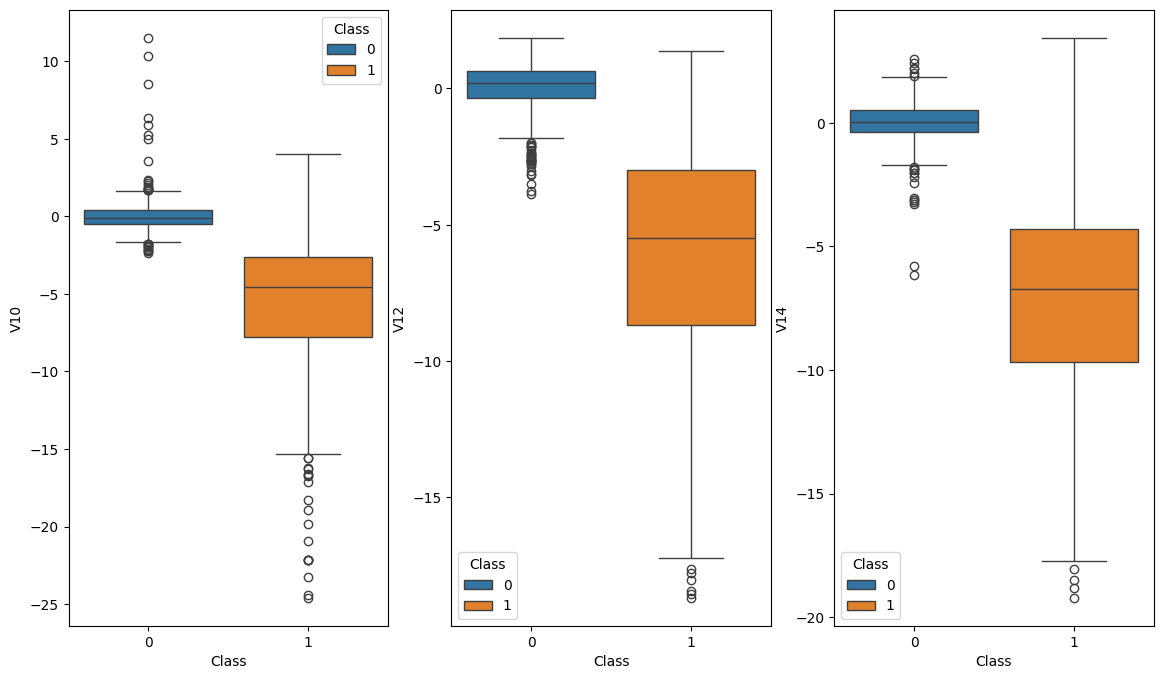

In [86]:
f, ax = plt.subplots(ncols=3, figsize=(14,8))

sns.boxplot(x='Class',y='V10',data=distribucion_balanceada, hue='Class',ax=ax[0])
sns.boxplot(x='Class',y='V12',data=distribucion_balanceada, hue='Class',ax=ax[1])
sns.boxplot(x='Class',y='V14',data=distribucion_balanceada, hue='Class',ax=ax[2])

**Primera impresion:**
- cuando una transaccion es legitimamente correcta, suele tener una caja angosta y sus puntas no son tan extensas
- Las transacciones fraudulentas suelen tener una caja muy grande y puntas extensas
- las cajas de la clase 1 siempre estan debajo de la ultima linea (Q4) de la clase 0

<Axes: xlabel='Class', ylabel='V11'>

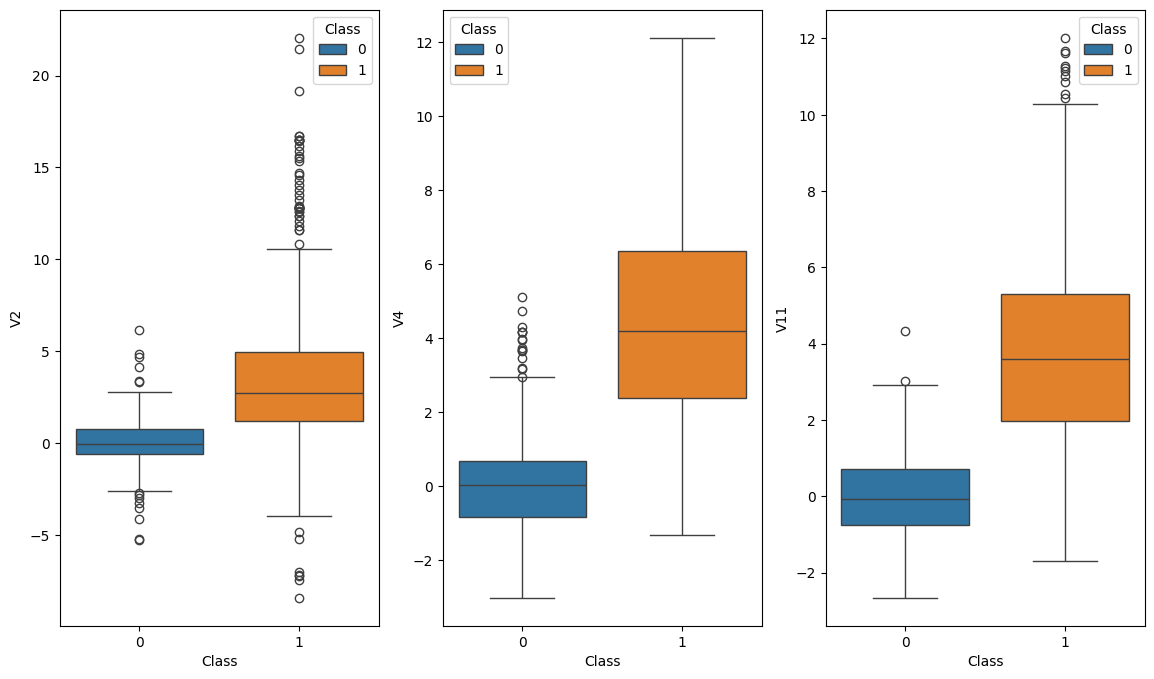

In [87]:
f, ax = plt.subplots(ncols=3, figsize=(14,8))

sns.boxplot(x='Class',y='V2', data=distribucion_balanceada, hue='Class', ax=ax[0])
sns.boxplot(x='Class',y='V4', data=distribucion_balanceada, hue='Class', ax=ax[1])
sns.boxplot(x='Class',y='V11', data=distribucion_balanceada, hue='Class', ax=ax[2])

Inversamente a lo que ocurre con los valores con correlaciones negativas, podemos ver una similitud en el comportamiento de estos valores, cuando es legitimo su caja es menor al tamaño de las cajas de las clases con etiqueta 1

---

¿Que nos queda ahora?

Ahora que tenemos una mejor idea sobre nuestros datos gracias a los graficos, vamos a pensar en una forma para que saquemos los valores atipicos, para esto podemos usar umbrales para que no perdamos gran cantidad de datos. Lo que se puede hacer es usar un rango para el umbral que nos acepte valores que excedan los bordes de la caja, es decir valores que esten por debajo del Q1 y arriba del Q3

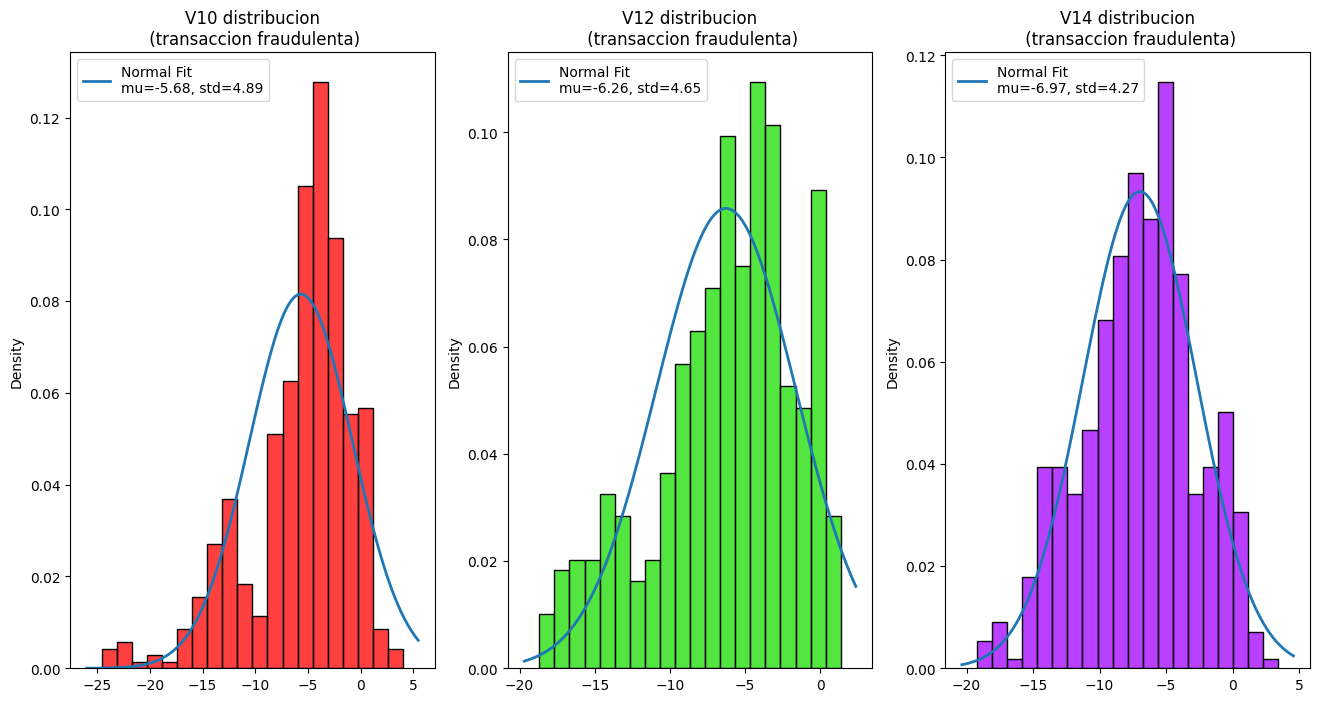

In [88]:
from scipy.stats import norm

f, ax = plt.subplots(1,3,figsize=(16,8))

v10 = distribucion_balanceada['V10'].loc[distribucion_balanceada['Class']==1].values
sns.histplot(v10, ax=ax[0], color="#FF0000",stat="density", kde=False, bins=20)
mu, std = norm.fit(v10)
#obtenemos los limites de x del grafico de V10 para que la curva se dibuje dentro de estos limites
xmin,xmax = ax[0].get_xlim()
x = np.linspace(xmin, xmax, 100) #ultimo argumento es usado para definicir la suavidad del trazado
#norm.fit define la altura de la curva
p = norm.pdf(x, mu, std)

ax[0].plot(x,p, linewidth=2,label=f'Normal Fit\nmu={mu:.2f}, std={std:.2f}')
ax[0].set_title('V10 distribucion\n (transaccion fraudulenta)')
ax[0].legend()

#-----------------------------------------------------------v12--------------------------------------------------
v12 = distribucion_balanceada['V12'].loc[distribucion_balanceada['Class']==1].values
sns.histplot(v12, ax=ax[1], color="#1ADD00",stat="density", kde=False, bins=20)
mu, std = norm.fit(v12)

xmin,xmax = ax[1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

ax[1].plot(x,p, linewidth=2,label=f'Normal Fit\nmu={mu:.2f}, std={std:.2f}')
ax[1].set_title('V12 distribucion\n (transaccion fraudulenta)')
ax[1].legend()

#-----------------------------------------------------------14-----------------------------------------------------
v14 = distribucion_balanceada['V14'].loc[distribucion_balanceada['Class']==1].values
sns.histplot(v14, ax=ax[2], color="#A200FF",stat="density", kde=False, bins=20)
mu, std = norm.fit(v14)

xmin,xmax = ax[2].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

ax[2].plot(x,p, linewidth=2,label=f'Normal Fit\nmu={mu:.2f}, std={std:.2f}')
ax[2].set_title('V14 distribucion\n (transaccion fraudulenta)')
ax[2].legend()

**Vamos a filtrar las features que tienen mayor correlacion respecto a 'Class' (que en este caso son las que tienen correlacion invertida/negativa)**

In [89]:
v10_fraude = distribucion_balanceada['V10'].loc[distribucion_balanceada['Class']==1].values
q25,q75 = np.percentile(v10_fraude,25), np.percentile(v10_fraude,75)

v10_iqr = q75 - q25
v10_cut_off = v10_iqr * 1.5

v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off

outliers = [x for x in v10_fraude if x < v10_lower or x > v10_upper]

dist_balanceada_filtrada = distribucion_balanceada.drop(
    distribucion_balanceada[
    (distribucion_balanceada['V10'] > v10_upper)
    | (distribucion_balanceada['V10'] < v10_lower)].index)



#----------------------------------------------------------------------------------------------------
v12_fraude = dist_balanceada_filtrada['V12'].loc[dist_balanceada_filtrada['Class']==1].values
q25,q75 = np.percentile(v12_fraude,25), np.percentile(v12_fraude,75)

v12_iqr = q75 - q25
v12_cut_off = v12_iqr * 1.5

v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off

outliers = [x for x in v12_fraude if x < v12_lower or x > v12_upper]

dist_balanceada_filtrada = dist_balanceada_filtrada.drop(
    dist_balanceada_filtrada[
    (dist_balanceada_filtrada['V12'] > v12_upper)
    | (dist_balanceada_filtrada['V12'] < v12_lower)].index)



#----------------------------------------------------------------------------------------------------
v14_fraude = dist_balanceada_filtrada['V14'].loc[dist_balanceada_filtrada['Class']==1].values
q25,q75 = np.percentile(v14_fraude,25), np.percentile(v14_fraude,75)

v14_iqr = q75 - q25
v14_cut_off = v14_iqr * 1.5

v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off

outliers = [x for x in v14_fraude if x < v14_lower or x > v14_upper]

dist_balanceada_filtrada = dist_balanceada_filtrada.drop(
    dist_balanceada_filtrada[
    (dist_balanceada_filtrada['V14'] > v14_upper)
    | (dist_balanceada_filtrada['V14'] < v14_lower)].index)

Chequeamos que se redujeran la mayor cantidad de outliers

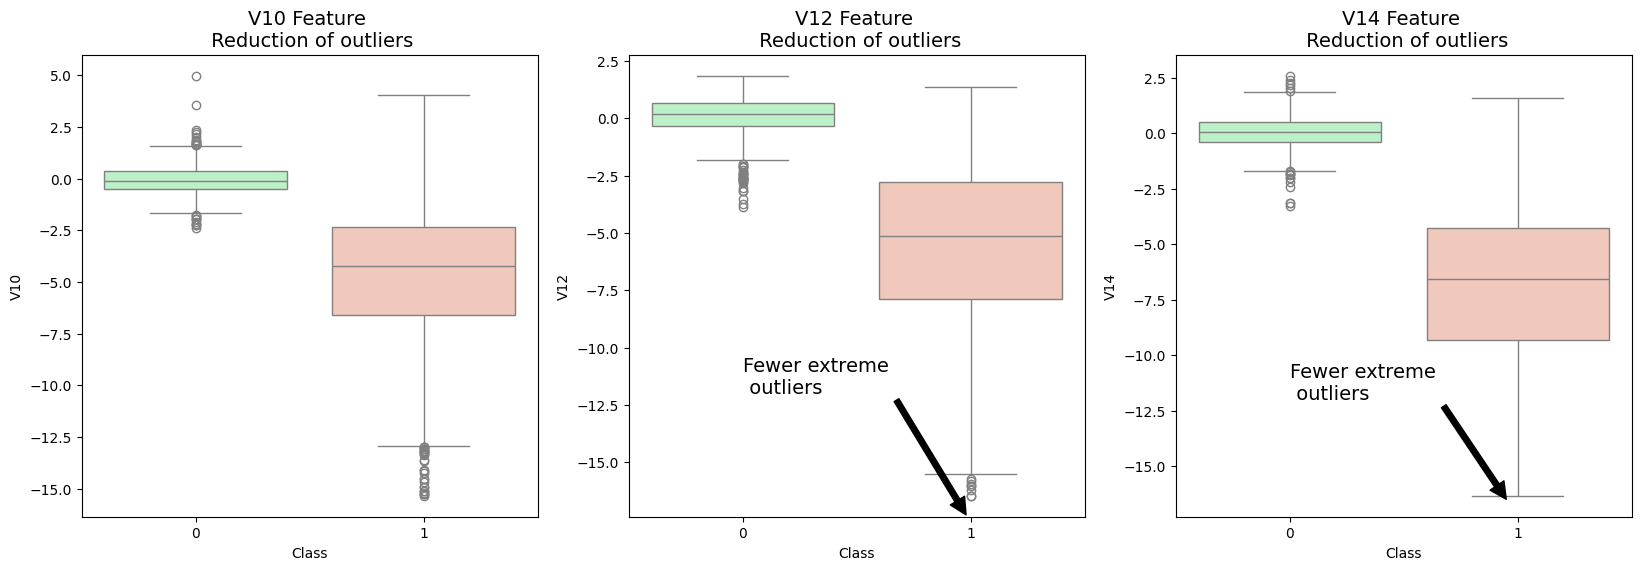

In [90]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V10
sns.boxplot(x="Class", y="V10", data=dist_balanceada_filtrada,ax=ax1, palette=colors)
ax1.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=dist_balanceada_filtrada, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V14", data=dist_balanceada_filtrada, ax=ax3, palette=colors)
ax3.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

Para la seleccion y disminucion de caracteristicas podemos elegir una variedad de tecnicas de reduccion  
En este ejemplo se ven 3:
- PCA
- SVD
- T-SNE

In [91]:
X = dist_balanceada_filtrada.drop('Class', axis=1)
y = dist_balanceada_filtrada['Class']

#tiempo de cronometrizacion inicial de T-SNE
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print(f'TSNE llevo: {t1-t0:.2}seg')

#tiempo de cronometrizacion inicial de PCA
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print(f'PCA llevo: {t1-t0:.2}seg')

#tiempo de cronometrizacion inicial de SVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print(f'Truncated SVD llevo: {t1-t0:.2}seg')

TSNE llevo: 1.0seg
PCA llevo: 0.001seg
Truncated SVD llevo: 0.0018seg


Observemos graficamente cual de estos metodos de reduccion es el que mejor separa los datos entre clases

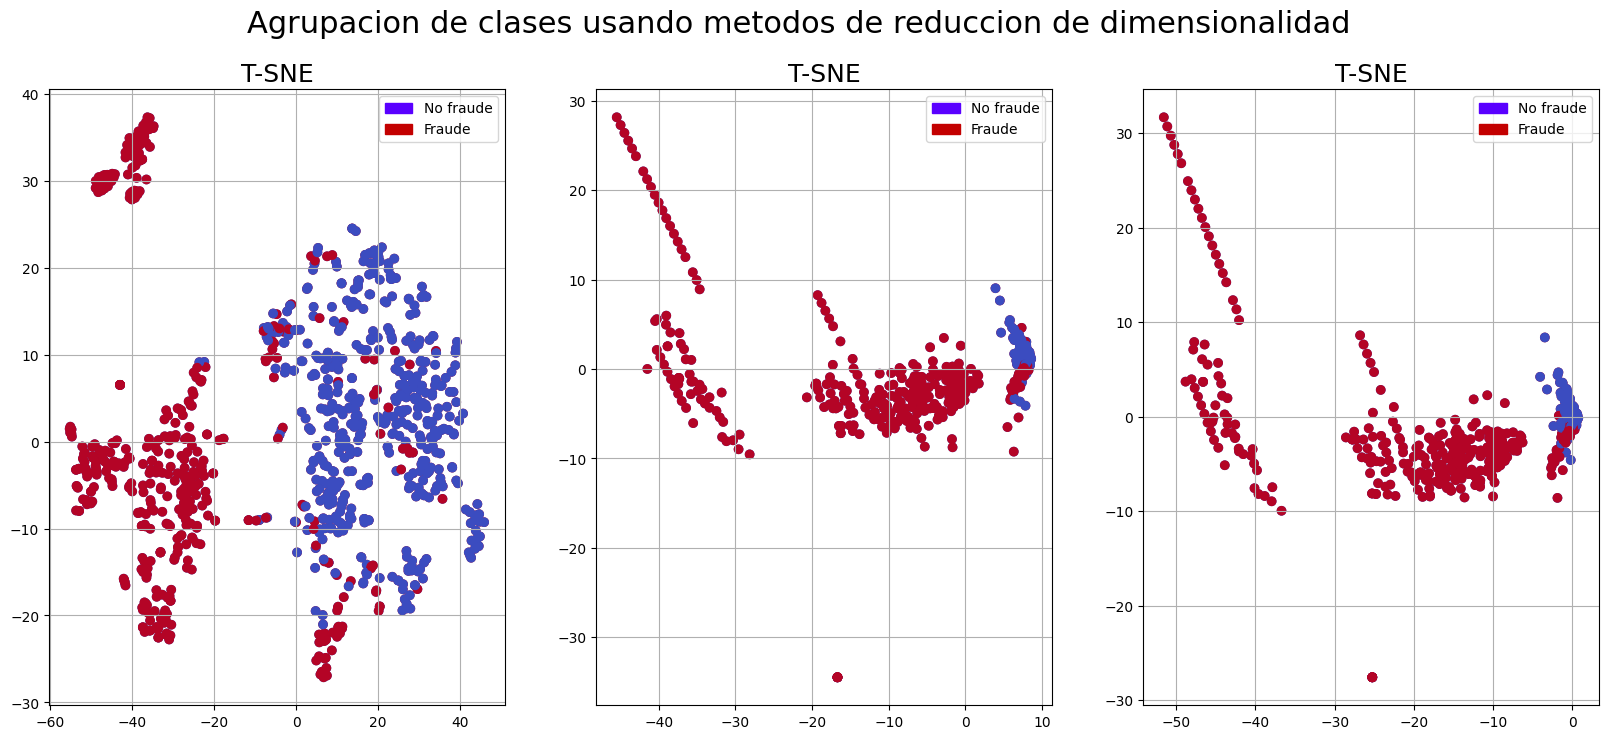

In [92]:
f, ax = plt.subplots(1,3,figsize=(20,8))
f.suptitle('Agrupacion de clases usando metodos de reduccion de dimensionalidad', fontsize=22)

blue_patch = mpatches.Patch(color="#5900ff", label='No fraude')
red_patch = mpatches.Patch(color="#c30000", label='Fraude')

#grafico de dispersion del metodo TSNE
ax[0].grid(True)
ax[0].scatter(X_reduced_tsne[:,0],X_reduced_tsne[:,1], c=(y==0), cmap='coolwarm', label='No fraude')
ax[0].scatter(X_reduced_tsne[:,0],X_reduced_tsne[:,1], c=(y==1), cmap='coolwarm', label='Fraude')
ax[0].set_title('T-SNE', fontsize=18)
ax[0].legend(handles=[blue_patch,red_patch])

#grafico de dispersion del metodo PCA
ax[1].grid(True)
ax[1].scatter(X_reduced_pca[:,0],X_reduced_pca[:,1], c=(y==0), cmap='coolwarm', label='No fraude')
ax[1].scatter(X_reduced_pca[:,0],X_reduced_pca[:,1], c=(y==1), cmap='coolwarm', label='Fraude')
ax[1].set_title('T-SNE', fontsize=18)
ax[1].legend(handles=[blue_patch,red_patch])

#grafico de dispersion del metodo Truncated SVD
ax[2].grid(True)
ax[2].scatter(X_reduced_svd[:,0],X_reduced_svd[:,1], c=(y==0), cmap='coolwarm', label='No fraude')
ax[2].scatter(X_reduced_svd[:,0],X_reduced_svd[:,1], c=(y==1), cmap='coolwarm', label='Fraude')
ax[2].set_title('T-SNE', fontsize=18)
ax[2].legend(handles=[blue_patch,red_patch])


Visualmente el que tiene una mejor distincion entre las clases es el metodo T-sne, mientras que las otras dos nos muestran una agrupacion dificil de separar, por lo que para un algoritmo seria muy costoso lograr una clasificacion correcta  

---
Voy a separar los datos en los conjuntos de test/train y a probar 4 clasificadores para ver cual es el que tiene mayor score

In [93]:
X = dist_balanceada_filtrada.drop('Class', axis=1)
y = dist_balanceada_filtrada['Class']

#con los datos ya escalados pasamos a dividirlos en conjuntos de entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#los conjuntos se convierten en arrays para entrenar los modelos
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

#vamos a probar con estos 4 modelos
classifiers = {
    "LogisticRegression":LogisticRegression(),
    "KNearest":KNeighborsClassifier(),
    "Support Vector Classifier":SVC(),
    "DecisionTreeClassifier":DecisionTreeClassifier()
}

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train,y_train, cv=5)
    print(f"El clasificador: {classifier}, obtuvo un score de: {training_score.mean()*100:.2f}%")


El clasificador: LogisticRegression(), obtuvo un score de: 94.28%
El clasificador: KNeighborsClassifier(), obtuvo un score de: 92.55%
El clasificador: SVC(), obtuvo un score de: 94.01%
El clasificador: DecisionTreeClassifier(), obtuvo un score de: 90.82%


In [94]:
from sklearn.model_selection import GridSearchCV

#parametros de la regresion logistica, este diccionario lo pasaremos para buscar en un GridSearch el mejor set de parametros
# regulacion l1=lasso, reduce a cero features, quitandolas de la evaluacion
# regulacion l2=ridge, reduce features no importantes dandole menos importancia
# C es la intensidad de la regulacion
log_reg_params = {"penalty":['l1','l2'], 'C':[0.001, 0.01, 0.1, 1.0 , 10.0, 100.0, 1000.0]}
# Pasamos por parametros el modelo que vamos a usar y el conjunto de regulaciones que va a tener durante el aprendizaje
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train,y_train)
#log_reg = grid_log_reg.best_estimator_ #en esta linea obtendremos el modelo ya entrenado, con los mejores parametros!
#log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
#print(f"El score de la Regresion logistica es de: {log_reg_score.mean()*100:.2f}%") 
print(f"El score de la Regresion logistica es de: {grid_log_reg.best_score_ *100:.2f}%") 

############

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_
print(f"El score de el Clasificador de Soportes Cectoriales es de: {grid_knears.best_score_ *100:.2f}%") 

############

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
print(f"El score de el Clasificador de Soportes Cectoriales es de: {grid_svc.best_score_ *100:.2f}%") 

############

tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
print(f"El score de el Clasificador del Arbol de Decision es de: {grid_tree.best_score_ *100:.2f}%") 


El score de la Regresion logistica es de: 94.41%
El score de el Clasificador de Soportes Cectoriales es de: 93.61%
El score de el Clasificador de Soportes Cectoriales es de: 94.54%
El score de el Clasificador del Arbol de Decision es de: 93.21%


In [95]:
svc = grid_svc.best_estimator_
knears_neighbors = grid_knears.best_estimator_
log_reg = grid_log_reg.best_estimator_
tree_clf = grid_tree.best_estimator_

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  94.41%
Knears Neighbors Cross Validation Score 93.61%
Support Vector Classifier Cross Validation Score 94.54%
DecisionTree Classifier Cross Validation Score 93.21%


**Como se vio en el grafico de los metodos de reduccion de dimensionalidad, los puntos azules y rojos, Nearmiss buscara aquellos puntos que esten mas cerca de la clase minoritaria (la clase fraude)**  
*Es decir que se entrenara con los puntos mas dificiles o ambiguos, ya que si se entrena solo con los puntos mas alejados/"faciles" este modelo solo sabra entender cuando un caso de fraude tenga una distancia euclidiana lo bastante grande como para diferenciarla de una transaccion legitima*  
*Caso contrario, malinterpretara cuando se de el caso de que un punto de la clase 1 este tan cerca de uno de la clase 0, dandose una clasificacion erronea del caso*

In [96]:

undersample_X = fraude.drop('Class', axis=1)
undersample_y = fraude['Class']
sss = StratifiedKFold()

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# ** El autor aclara que este paso es solo para verificar la distribucion de las etiquetas, no se usara este conjunto para entrenar **
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

# Cross Validating the right way
for train_index, test_index in sss.split(undersample_X, undersample_y):
    
    # 1. Definir los subconjuntos para este fold
    X_train_fold, X_test_fold = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    y_train_fold, y_test_fold = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
    # 2. Crear y entrenar el pipeline
    # *el submuestreo se aplica solo al conjunto de entrenamiento, y no al conjunto completo para evitar dataleakage
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg)
    undersample_model = undersample_pipeline.fit(X_train_fold, y_train_fold)
    
    # 3. Hacer predicciones en el set de test de este fold
    undersample_prediction = undersample_model.predict(X_test_fold)
    
    # 4. Usar las métricas para evaluar
    # Aquí puedes usar .score para calcular accuracy
    undersample_accuracy.append(undersample_model.score(X_test_fold, y_test_fold))
    
    # Y el resto de las métricas que necesitan la predicción
    undersample_precision.append(precision_score(y_test_fold, undersample_prediction))
    undersample_recall.append(recall_score(y_test_fold, undersample_prediction))
    undersample_f1.append(f1_score(y_test_fold, undersample_prediction))
    undersample_auc.append(roc_auc_score(y_test_fold, undersample_prediction))

NearMiss Label Distribution: Counter({np.int64(0): 492, np.int64(1): 492})


Vamos a chequear progresivamente aumentando la cantidad de valores de entrenamiento y prueba para ver si el modelo sobreajusta o subajusta a medida que crece la cantidad de conjuntos train/test

<module 'matplotlib.pyplot' from '/media/mjb/Back-up/disco_rigido/documentos/proyectos/transacciones_fraudes/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

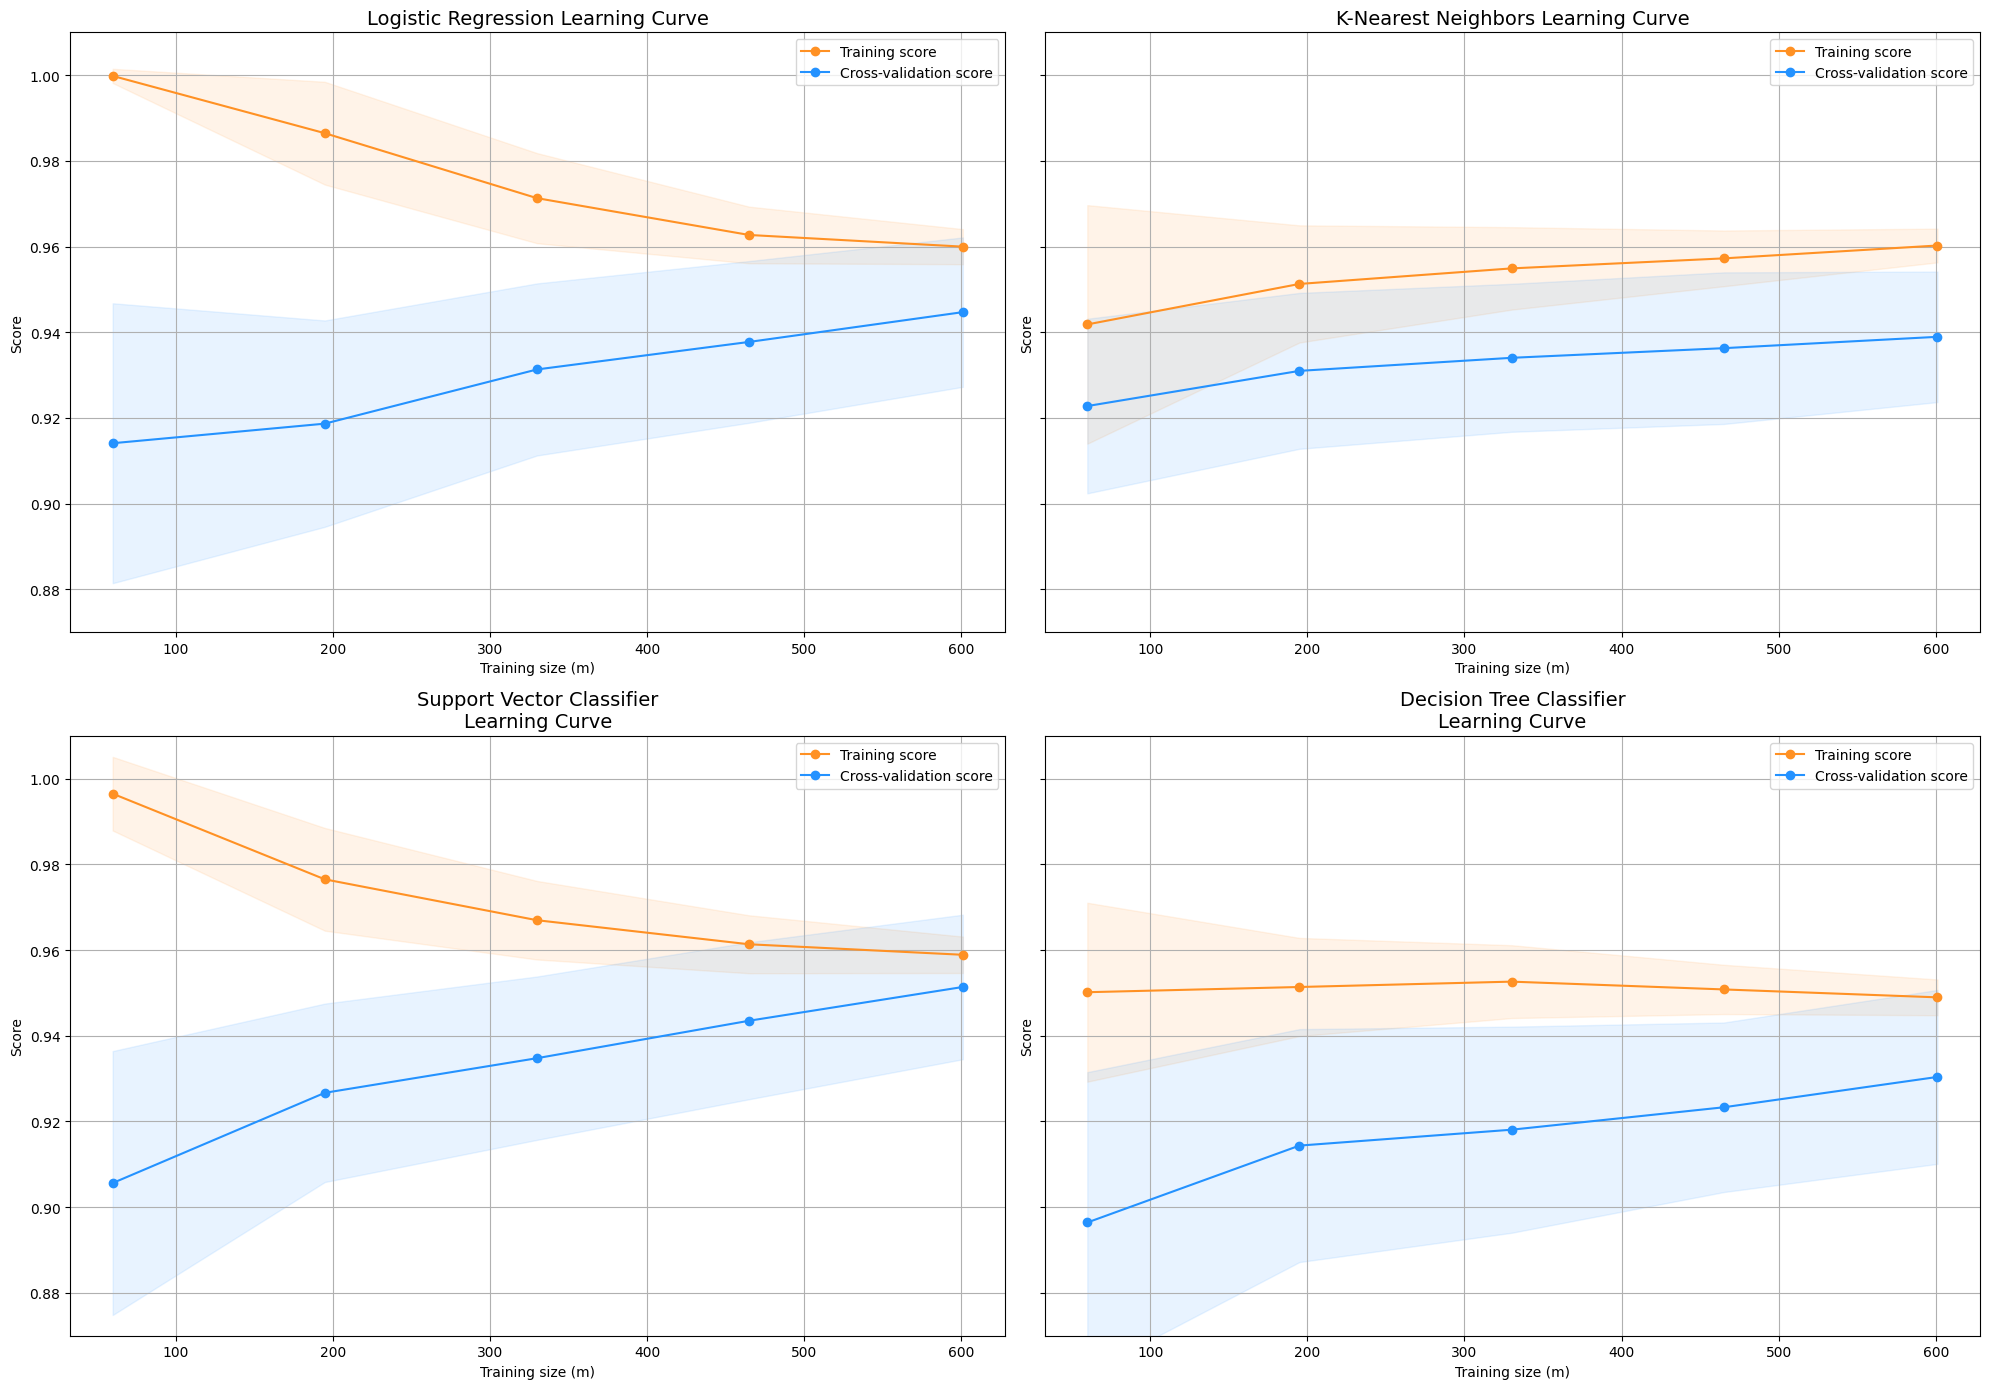

In [97]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(estimators, X, y, titles=None, ylim=None, cv=None, 
                       n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Genera learning curves para múltiples estimadores en una grilla 2x2.
    
    Args:
        estimators: lista de estimadores
        X, y: datos de entrenamiento
        titles: lista de títulos para cada subplot (opcional)
        ylim: límites del eje y
        cv: estrategia de cross-validation
        n_jobs: número de trabajos paralelos
        train_sizes: tamaños de entrenamiento a evaluar
    """
    
    # Títulos por defecto si no se proporcionan
    if titles is None:
        titles = [f"Estimator {i+1} Learning Curve" for i in range(len(estimators))]
    
    # Crear figura con subplots
    f, axes = plt.subplots(2, 2, figsize=(20, 14), sharey=True)
    axes = axes.flatten()  # Convertir a array 1D para fácil iteración
    
    if ylim is not None:
        plt.ylim(*ylim)
    
    # Función auxiliar para crear cada subplot
    def create_subplot(estimator, ax, title):
        train_sizes_cur, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
        )
        
        # Calcular medias y desviaciones estándar
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
        # Crear las áreas sombreadas
        ax.fill_between(train_sizes_cur, 
                       train_scores_mean - train_scores_std,
                       train_scores_mean + train_scores_std, 
                       alpha=0.1, color="#ff9124")
        ax.fill_between(train_sizes_cur, 
                       test_scores_mean - test_scores_std,
                       test_scores_mean + test_scores_std, 
                       alpha=0.1, color="#2492ff")
        
        # Crear las líneas principales
        ax.plot(train_sizes_cur, train_scores_mean, 'o-', 
               color="#ff9124", label="Training score")
        ax.plot(train_sizes_cur, test_scores_mean, 'o-', 
               color="#2492ff", label="Cross-validation score")
        
        # Configurar el subplot
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Training size (m)')
        ax.set_ylabel('Score')
        ax.grid(True)
        ax.legend(loc="best")
    
    # Crear cada subplot iterando sobre estimadores
    for i, (estimator, title) in enumerate(zip(estimators, titles)):
        if i < len(axes):  # Asegurar que no excedamos el número de subplots
            create_subplot(estimator, axes[i], title)
    
    plt.tight_layout()
    return plt

# Uso de la función optimizada
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

# Definir estimadores y títulos
estimators = [log_reg, knears_neighbors, svc, tree_clf]
titles = [
    "Logistic Regression Learning Curve",
    "K-Nearest Neighbors Learning Curve", 
    "Support Vector Classifier\nLearning Curve",
    "Decision Tree Classifier\nLearning Curve"
]

# Llamar a la función
plot_learning_curve(estimators, X_train, y_train, titles=titles, 
                   ylim=(0.87, 1.01), cv=cv, n_jobs=4)

Aqui el autor basicamente esta comparando a los 4 modelos con:
- la misma metodologia: cross validation de 5 folds
- con las mismas metricas: ROC AUC Score

In [98]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5, method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5, method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

from sklearn.metrics import roc_auc_score

#importante, en esta ocasion usamos y_train debido a que el cross validation utiliza divisiones, evitando que los datos vean por completo
# los datosde todo el conjunto, asi evitando el Data Leakage
print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9784043276311317
KNears Neighbors:  0.9349155998640534
Support Vector Classifier:  0.9790911408179449
Decision Tree Classifier:  0.927013707941543


Para dejarlo mas visible, en el siguiente grafico, la curva de la Regresion Logistica sobrepasa a la del clasificador del vector de soporte  
- el tpr de cada modelo representa la tasa de verdaderos positivos, es decir que porcentaje de las transacciones evaluadas como fraude son reales
- el fpr, es la tasa de falsos positivos, en forma resumida es el porcentaje de los que se consideraban fraude cuando en realidad no lo eran

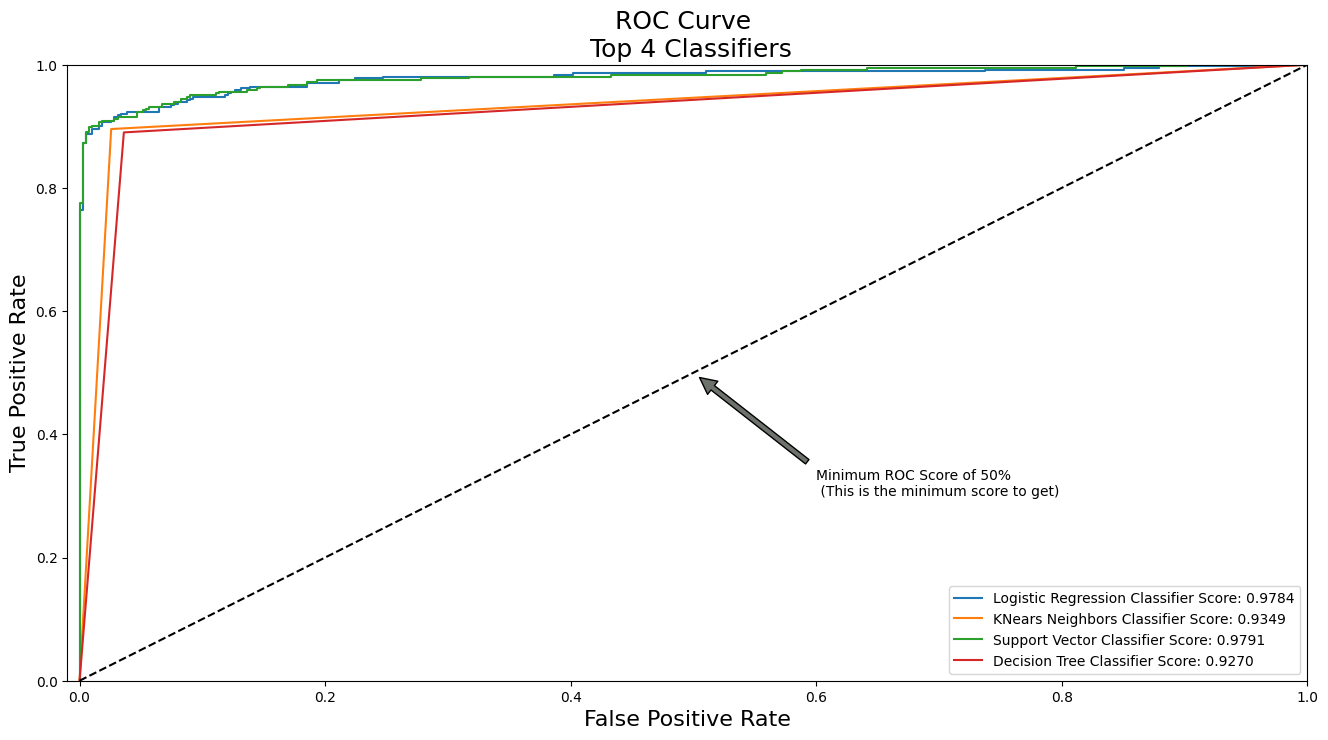

In [99]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

El siguiente codigo va a evaluar la puntuacion de prediccion en dos formas:  
- primero el modelo, estara usando los mismo datos de entrenamiento, es decir datos que el modelo ya vio
- segundo se vera con validacion cruzada que puntuacion obtenemos, para tener una idea mas real de su rendimiento con datos nuevos

In [100]:
y_pred = log_reg.predict(X_train)

#primero
print("\n")
print("Primer caso")
print(f"Recall Score: {recall_score(y_train, y_pred):.2f}")
print(f"Precision Score: {precision_score(y_train, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_train, y_pred):.2f}")
print(f"Accuracy Score: {accuracy_score(y_train, y_pred):.2f}")

#segundo
print("\n")
print("segundo caso")
print(f"Recall Score: {np.mean(undersample_recall)}")
print(f"Precision Score: {np.mean(undersample_precision)}")
print(f"F1 Score: {np.mean(undersample_f1)}")
print(f"Accuracy Score: {np.mean(undersample_accuracy)}")
print("\n")



Primer caso
Recall Score: 0.94
Precision Score: 0.62
F1 Score: 0.75
Accuracy Score: 0.70


segundo caso
Recall Score: 0.9390847247990106
Precision Score: 0.0036203251236237113
F1 Score: 0.0072123741781545524
Accuracy Score: 0.5465487573748413




f1 score y precision score son muy bajos vamos a probar la funcion de average_precision_score de scikit-learn comparando tanto el conjunto original como el conjunto balanceado para ver su promedio final

In [101]:
undersample_y_score = log_reg.decision_function(original_Xtest)

from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.03


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.03')

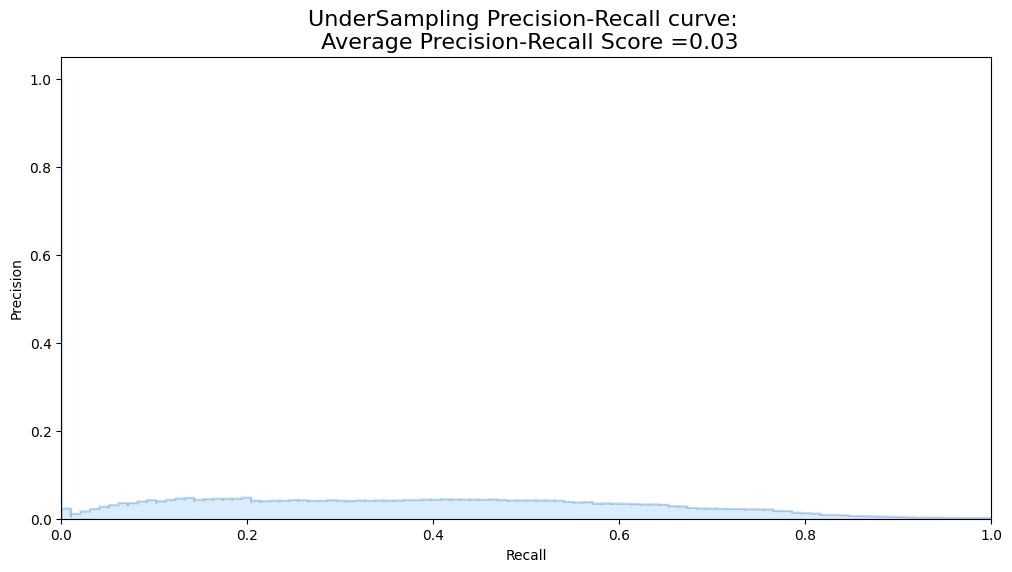

In [102]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

## **Basicamente en el grafico vemos el puntaje total de ambos conjuntos y es super pobre, no esta logrando tener el mismo resultado al que se enfrenta el modelo cuando se encuentra con conjuntos de datos desbalanceados, si bien obtenemos buenos resultados cuando se encuentra con los conjuntos balanceados se pierde completamente esa ventaja cuando los comparamos con los datos originales**

---


#  
Utilizando la tecnica SMOTE


# **SMOTE**

Dado los resultados ahora vamos a probar con la creacion de datos sinteticos, para aumentar la cantidad de datos de las minorias

In [103]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

print(f"lenght of X (Train): {len(original_Xtrain)}, lenght of y (Train): {len(original_ytrain)}")
print(f"lenght of X (Test): {len(original_Xtest)}, lenght of y (Test): {len(original_ytest)}")

lenght of X (Train): 227846, lenght of y (Train): 227846
lenght of X (Test): 56961, lenght of y (Test): 56961


In [ ]:
accuracy_list=[]
precision_list=[]
recall_list=[]
f1_list=[]
auc_list=[]

log_reg_sm = LogisticRegression()
#Recordar que aca se va a combinar todas las formas diferentes de parametros durante 4 iteraciones de validacion cruzada con el fin de obtener
# los mejores parametros
random_log_reg = RandomizedSearchCV(LogisticRegression(),log_reg_params, n_iter=4)

***Dato importante:**
- el autor en el texto aclara que para evitar *data leakage* es decir que el modelo se entrene con datos ya vistos, se los separe previamente para que cada fold realice un oversampling evitando asi que los mismos datos vean los mismos datos sinteticos de los otros folds

In [ ]:

for train, test in sss.split(original_Xtrain, original_ytrain):
    #adentro del fold es que vamos a utilizar la tecnica SMOTE para crear datos sinteticos
    # *IMPORTANTE: ImbalMakePip... lo que hace es crear datos sinteticos del conjunto de entrenamiento no del conjunto de pruebas
    #   evitando asi la fuga de datos
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), random_log_reg)
    model = pipeline.fit(original_Xtrain.iloc[train], original_ytrain.iloc[train])
    best_est = random_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain.iloc[test])
    
    #comparamos tambien los test de precision score, recall score, f1 score y el score de la curva ROC
    accuracy_list.append(pipeline.score(original_Xtrain.iloc[test], original_ytrain.iloc[test]))
    precision_list.append(precision_score(original_ytrain.iloc[test], prediction))
    recall_list.append(recall_score(original_ytrain.iloc[test], prediction))
    f1_list.append(f1_score(original_ytrain.iloc[test], prediction))
    auc_list.append(roc_auc_score(original_ytrain.iloc[test], prediction))


In [117]:
print(f"Accuracy: {np.mean(accuracy_list)}")
print(f"Precision: {np.mean(precision_list)}")
print(f"Recall: {np.mean(recall_list)}")
print(f"F1: {np.mean(f1_list)}")

Accuracy: 0.9433351881625442
Precision: 0.06284370742169366
Recall: 0.9137617656604998
F1: 0.11575433961117051


In [121]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.12      0.86      0.20        98

    accuracy                           0.99     56961
   macro avg       0.56      0.92      0.60     56961
weighted avg       1.00      0.99      0.99     56961



En el reporte vemos que la clase "No fraud" es decir transacciones legitimas, no tiene problemas para acertar cuando una es real de una falsa.
Sin embargo por el lado de las transacciones fraudes (Fraud) se nota que en la precision cae mucho, dado que esta prediciendo algunas transacciones como fraudulentas cuando en realidad no lo son

In [ ]:
#vamos a probar con las puntuaciones de confianza
y_score = best_est.decision_function(original_Xtest)

average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.75


En el caso de las puntuaciones de confianza estas no devuelven etiquetas o probabilidades, si no puntuaciones de que tan seguro esta el modelo de tener un caso u otro, por ejemplo si esta seguro que un valor podria ser positivo va a devolver valores altos arriba del umbral de 0 (ej:2.5, caso de que sea fraude), y si esta seguro que es negativo, valores por debajo de 0 (ej:-1.8 que es el caso de No fraude), lo que vamos a conseguir es una lista de valores con estos puntajes y el average precision score, va a comparar entre las etiquetas del set original con estos nuevos puntajes

Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.75')

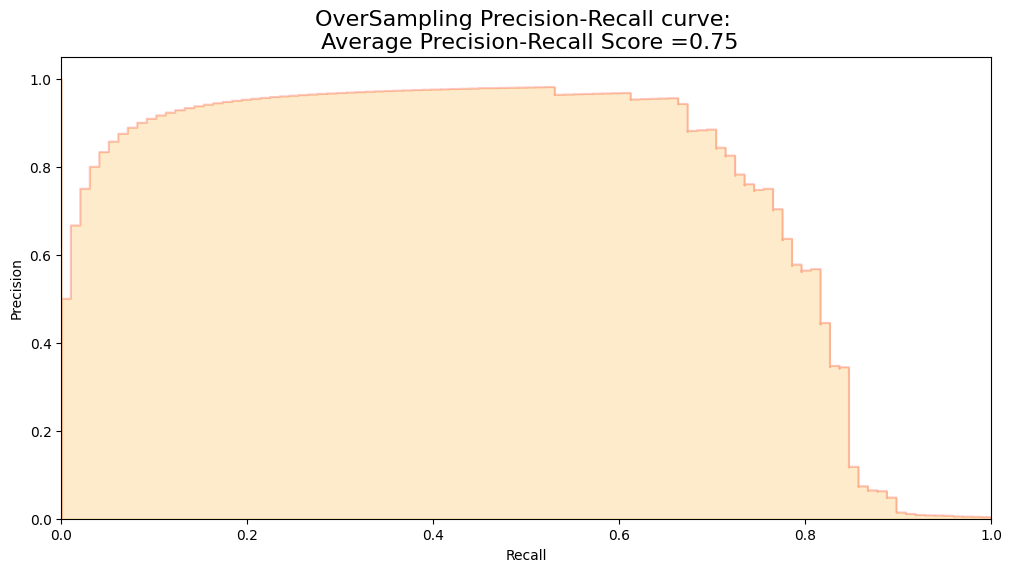

In [124]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [ ]:
sm = SMOTE(sampling_strategy='minority', random_state=42)

# recordar que la tecnica SMOTE solo va en el conjunto de entrenamiento
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [ ]:
# Regrresión logistica
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print(f"El entrenamiento con datos sobremuestreados llevo :{t1 - t0} segundos")

El entrenamiento con datos sobremuestreados llevo :3.0222561359405518 segundos


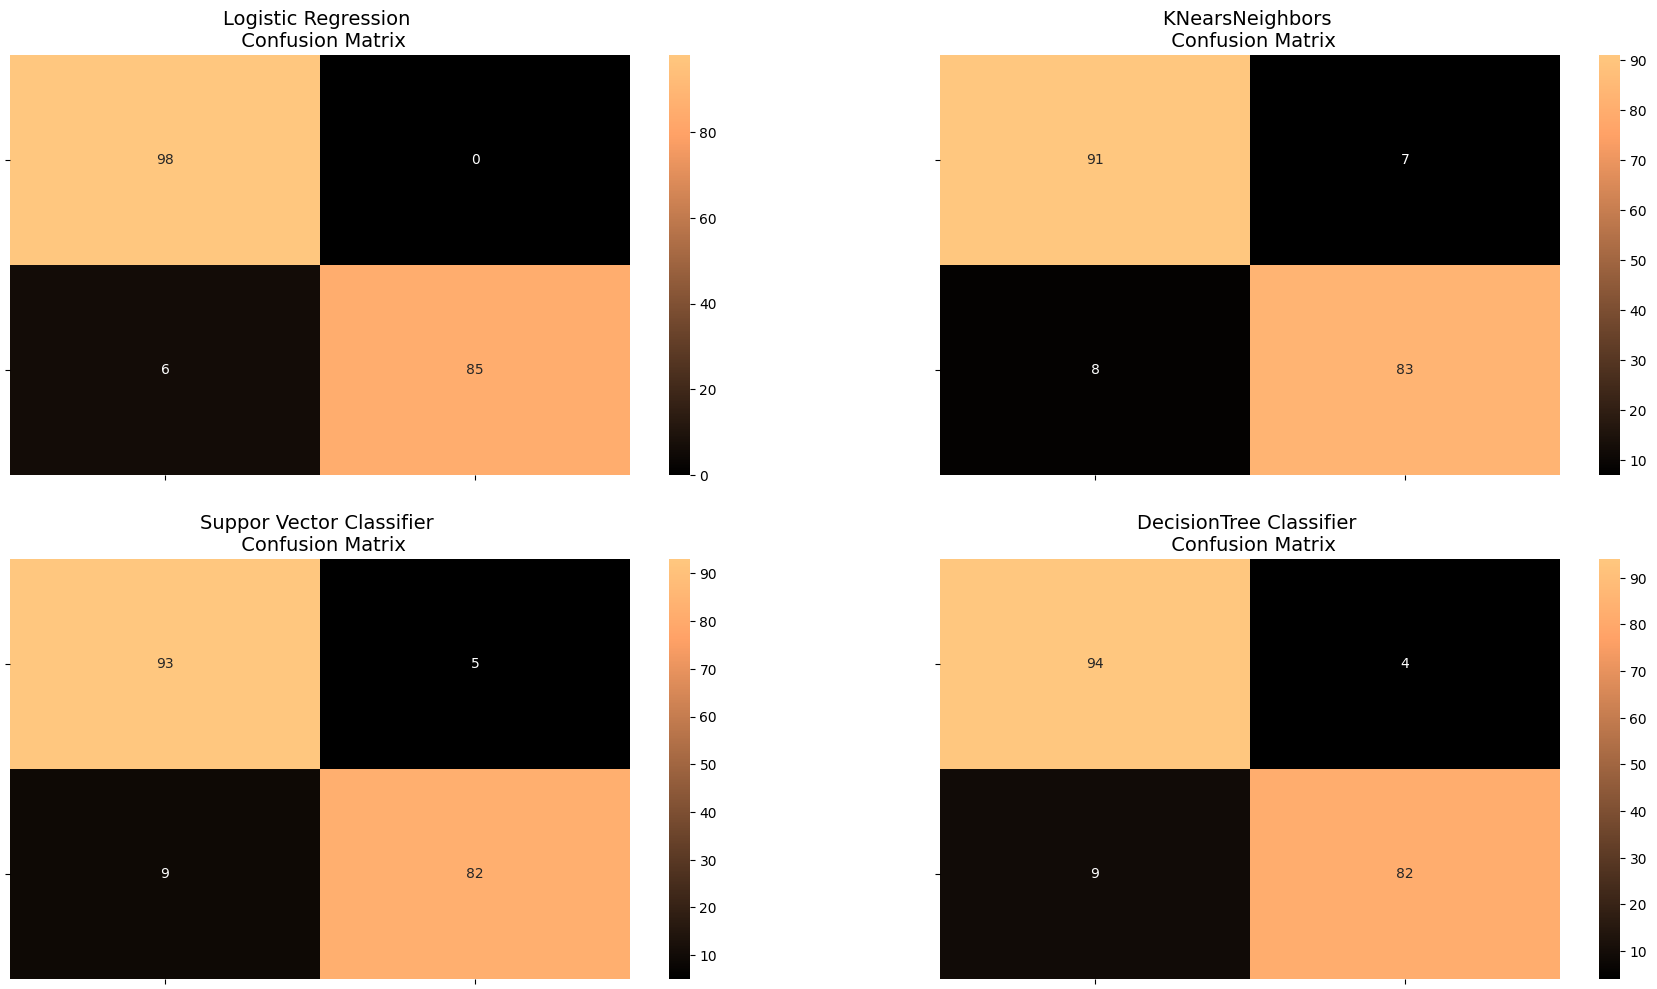

In [129]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

**Logistic Regression tiene:**  
- 98 true negatives, muestras que fueron predichas correctamente como "negativas"(no fraude)
- 6 false negatives, muestras que fueron mal predichas, muestras que debieron ser positivos, quedaron etiquetados como negativos
- 0 false positives, muestras que fueron erroneamente predichas como "positivas"(fraude)
- 85 true positives, muestras correctamente predichas como fraude

**Support Vector Classifier tiene:**  
- 93 true negatives, muestras que fueron predichas correctamente como "negativas"(no fraude)
- 9 false negatives, muestras que fueron mal predichas, muestras que debieron ser positivos, quedaron etiquetados como negativos
- 5 false positives, muestras que fueron erroneamente predichas como "positivas"(fraude)
- 82 true positives, muestras correctamente predichas como fraude

**KNearsNeighbors tiene:**  
- 91 true negatives, muestras que fueron predichas correctamente como "negativas"(no fraude)
- 8 false negatives, muestras que fueron mal predichas, muestras que debieron ser positivos, quedaron etiquetados como negativos
- 7 false positives, muestras que fueron erroneamente predichas como "positivas"(fraude)
- 83 true positives, muestras correctamente predichas como fraude

**DecisionTree Classifier tiene:**  
- 94 true negatives, muestras que fueron predichas correctamente como "negativas"(no fraude)
- 9 false negatives, muestras que fueron mal predichas, muestras que debieron ser positivos, quedaron etiquetados como negativos
- 4 false positives, muestras que fueron erroneamente predichas como "positivas"(fraude)
- 82 true positives, muestras correctamente predichas como fraude



In [131]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        98
           1       1.00      0.93      0.97        91

    accuracy                           0.97       189
   macro avg       0.97      0.97      0.97       189
weighted avg       0.97      0.97      0.97       189

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92        98
           1       0.92      0.91      0.92        91

    accuracy                           0.92       189
   macro avg       0.92      0.92      0.92       189
weighted avg       0.92      0.92      0.92       189

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        98
           1       0.94      0.90      0.92        91

    accuracy                           0.93       189
   macro avg       0.93      0.93      0.93       189
weighted

**por ultimo la comparativa de accuracy entre el SMOTE y la tecnica de undersample**

In [132]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading! 
final_df

,Technique,Score
0,Random UnderSampling,0.968254
1,Oversampling (SMOTE),0.988413
